In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train.shape, test.shape, submission.shape
train.head(3)
test.head(3)
submission.head(3)

((45532, 77), (11383, 76), (11383, 1))

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,...,0,1,0,1,1,0,1,0,1,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,...,1,1,0,1,1,0,1,0,1,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,...,1,1,0,1,1,1,1,0,1,1


,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,736,2.0,2941,3.0,4621,1.0,4857,2.0,2550,...,0,1,0,0,1,0,1,0,1,1
1,3.0,514,2.0,1952,3.0,1552,3.0,821,4.0,1150,...,0,0,0,0,0,0,0,0,0,0
2,3.0,500,2.0,2507,4.0,480,2.0,614,2.0,1326,...,0,1,0,1,1,0,1,0,1,1


,voted
index,
0,0
1,0
2,0


# 2. EDA & 전처리

In [5]:
df = pd.concat([train, test])
df.shape

(56915, 77)

In [6]:
train.info

<bound method DataFrame.info of        QaA   QaE  QbA   QbE  QcA   QcE  QdA   QdE  QeA   QeE  ...  wr_04  \
index                                                         ...          
0      3.0   363  4.0  1370  5.0   997  1.0  1024  2.0  1577  ...      0   
1      5.0   647  5.0  1313  3.0  3387  5.0  2969  1.0  4320  ...      1   
2      4.0  1623  1.0  1480  1.0  1021  4.0  3374  5.0  1333  ...      1   
3      3.0   504  3.0  2311  4.0   992  3.0  3245  1.0   357  ...      0   
4      1.0   927  1.0   707  5.0   556  2.0  1062  1.0  1014  ...      1   
...    ...   ...  ...   ...  ...   ...  ...   ...  ...   ...  ...    ...   
45527  2.0  1050  5.0   619  4.0   328  1.0   285  1.0   602  ...      1   
45528  2.0   581  3.0  1353  4.0  1164  1.0   798  3.0  1680  ...      1   
45529  4.0   593  1.0   857  1.0  1047  4.0  1515  5.0  1690  ...      1   
45530  1.0   747  3.0  1331  4.0   892  2.0  1281  1.0  1328  ...      1   
45531  3.0   496  5.0  1827  5.0   754  3.0  1117  1.0  

## Missing Value

In [7]:
train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

## 컬럼 분류

In [8]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

,gbn,dtl
col,,
QaA,Q_A,a
QaE,Q_E,a
QbA,Q_A,b
QbE,Q_E,b
QcA,Q_A,c
...,...,...
wr_09,wr,
wr_10,wr,
wr_11,wr,


### Q_A

In [9]:
Q_A = meta[meta.gbn=='Q_A'].index

train[Q_A].describe()
train[Q_A].head(3)

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,2.129535,2.904463,3.662347,1.749078,2.317952,2.168145,2.560595,2.317952,3.157691,3.575529,3.813933,4.325727,3.509620,2.632896,3.217232,3.071752,2.840464,2.823487,3.432948,3.225687
std,1.196952,1.566142,1.431494,1.043625,1.369205,1.348653,1.510600,1.460813,1.481740,1.361220,1.372551,1.146992,1.375134,1.473022,1.476414,1.489744,1.404342,1.424383,1.374938,1.521603
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,3.000000,4.000000,5.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
index,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,5.0,1.0,2.0,5.0,2.0,4.0,5.0,4.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0
1,5.0,5.0,3.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,5.0,4.0,1.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0
2,4.0,1.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,2.0,5.0,5.0,2.0,4.0,2.0,1.0,5.0,4.0,1.0,1.0


### Q_A 1/5 count

In [10]:
# Q_A: 1~5 1/5 극단값 선택한 count 추출
train['Q_A1'] = 0
train['Q_A3'] = 0
train['Q_A5'] = 0

test['Q_A1'] = 0
test['Q_A3'] = 0
test['Q_A5'] = 0

In [11]:
%%time
for f in Q_A:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'Q_A1'] = train.loc[i, 'Q_A1']+1
        elif v == 3:
            train.loc[i, 'Q_A3'] = train.loc[i, 'Q_A3']+1
        elif v == 5:
            train.loc[i, 'Q_A5'] = train.loc[i, 'Q_A5']+1            

Wall time: 5min 54s


In [12]:
%%time
for f in Q_A:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'Q_A1'] = test.loc[i, 'Q_A1']+1
        elif v == 3:
            test.loc[i, 'Q_A3'] = test.loc[i, 'Q_A3']+1            
        elif v == 5:
            test.loc[i, 'Q_A5'] = test.loc[i, 'Q_A5']+1                        

Wall time: 1min 4s


### Q_E

In [13]:
Q_E = meta[meta.gbn == 'Q_E'].index

train[Q_E].describe()
train[Q_E].head()

,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
count,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04
mean,9.453570e+02,2.189589e+03,1484.294518,1.490672e+03,1.899292e+03,1.850650e+03,1.284608e+03,4.584272e+03,4.068434e+03,2.576363e+03,2.038986e+03,3.741018e+03,2.050287e+03,959.880502,1.435762e+03,1.633479e+03,1.154352e+03,2.470808e+03,1.164117e+03,2.240057e+03
std,1.307565e+04,3.351027e+04,8977.664318,1.092260e+04,1.670765e+04,7.608236e+04,9.756584e+03,5.020265e+05,1.141738e+05,5.411432e+04,3.069164e+04,3.663672e+05,7.530787e+04,5869.964127,1.084997e+04,2.600221e+04,2.250689e+04,1.482890e+05,7.433515e+03,6.730924e+04
min,2.500000e+01,2.500000e+01,25.000000,2.600000e+01,2.500000e+01,2.500000e+01,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,25.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,2.500000e+01
25%,4.040000e+02,8.750000e+02,651.000000,6.790000e+02,8.340000e+02,5.040000e+02,5.490000e+02,1.077000e+03,1.259000e+03,9.020000e+02,8.590000e+02,8.060000e+02,6.500000e+02,428.000000,6.380000e+02,7.060000e+02,4.610000e+02,7.940000e+02,5.270000e+02,7.330000e+02
50%,5.570000e+02,1.218000e+03,899.000000,9.310000e+02,1.154000e+03,7.120000e+02,7.720000e+02,1.464000e+03,1.800000e+03,1.260000e+03,1.178000e+03,1.125000e+03,9.060000e+02,596.000000,8.830000e+02,9.700000e+02,6.520000e+02,1.117000e+03,7.470000e+02,1.020000e+03
75%,8.270000e+02,1.838000e+03,1335.000000,1.355000e+03,1.656000e+03,1.078000e+03,1.150000e+03,2.090000e+03,2.761000e+03,1.899000e+03,1.721000e+03,1.649000e+03,1.342000e+03,891.000000,1.300000e+03,1.409000e+03,9.820000e+02,1.664000e+03,1.124000e+03,1.526000e+03
max,2.413960e+06,5.580395e+06,871557.000000,1.552821e+06,1.919926e+06,1.176370e+07,1.068252e+06,1.070860e+08,1.703586e+07,9.910006e+06,4.824953e+06,7.754351e+07,1.410832e+07,606694.000000,1.309739e+06,4.650742e+06,4.277510e+06,3.159328e+07,1.286581e+06,1.155650e+07


,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
index,,,,,,,,,,,,,,,,,,,,
0,363,1370,997,1024,1577,539,586,1095,1142,1287,883,851,851,816,579,924,366,876,633,1115
1,647,1313,3387,2969,4320,2190,826,4082,1867,1264,2943,3927,4329,1828,1214,2414,1356,3039,4304,1346
2,1623,1480,1021,3374,1333,531,1167,1016,2653,1569,998,2547,918,2153,1304,1131,937,1327,1170,1409
3,504,2311,992,3245,357,1519,159,2275,2809,5614,3219,1296,9046,1216,1169,23868,581,8830,2392,1312
4,927,707,556,1062,1014,628,991,1259,1153,1388,740,1181,547,575,754,1140,323,1070,583,1889


### tp

In [14]:
# 0~7 
tp = meta[meta.gbn=='tp'].index

train[tp].describe()
train[tp].head(3)

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,3.017241,2.621189,1.768712,3.041246,1.335918,2.472217,2.031099,3.507226,2.277497,4.317996
std,2.007713,1.897081,1.685069,2.037278,1.452544,2.000658,1.785824,1.971456,1.848783,1.722793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000
50%,3.000000,2.000000,1.000000,3.000000,1.000000,2.000000,2.000000,4.000000,2.000000,5.000000
75%,5.000000,4.000000,3.000000,5.000000,2.000000,4.000000,3.000000,5.000000,4.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
0,2,2,2,1,2,1,7,4,4,3
1,1,1,0,0,1,2,3,4,0,4
2,2,3,1,5,3,4,2,6,1,3


In [15]:
# tp: 1,7 극단값 선택한 count 추출, 4 중간값 선택 count 
train['tp17'] = 0
train['tp4'] = 0

test['tp17'] = 0
test['tp4'] = 0

In [16]:
%%time
for f in tp:
    for i, v in enumerate(train[f]):
        if (v == 1 | v == 7):
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        if v == 4:
            train.loc[i, 'tp4'] = train.loc[i, 'tp4']+1            

Wall time: 43.1 s


In [17]:
%%time
for f in tp:
    for i, v in enumerate(test[f]):
        if (v == 1 | v == 7):
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        if v == 4:
            test.loc[i, 'tp4'] = test.loc[i, 'tp4']+1            

Wall time: 4.03 s


#### 극단값 중간값

In [18]:
train['Q_A15tp17'] = train['Q_A1'] + train['Q_A5'] + train['tp17']
train['Q_A3tp4'] = train['Q_A3'] + train['tp4']

In [19]:
test['Q_A15tp17'] = test['Q_A1'] + test['Q_A5'] + test['tp17']
test['Q_A3tp4'] = test['Q_A3'] + test['tp4']

In [20]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

,wf_01,wf_02,wf_03
count,45532.000000,45532.000000,45532.000000
mean,0.079592,0.163665,0.118356
std,0.270664,0.369975,0.323033
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


,wf_01,wf_02,wf_03
index,,,
0,0,0,0
1,0,0,0
2,0,0,1


In [21]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,0.709721,0.934793,0.208974,0.868708,0.895722,0.328538,0.938900,0.972195,0.202824,0.946104,0.395195,0.947729,0.927040
std,0.453896,0.246893,0.406580,0.337723,0.305625,0.469687,0.239516,0.164414,0.402107,0.225815,0.488898,0.222575,0.260073
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,
0,0,1,0,0,1,0,1,1,0,1,0,1,1
1,0,1,0,1,1,0,1,1,0,1,0,1,1
2,1,1,0,1,1,0,1,1,1,1,0,1,1


## Target Encoding

### age_group

In [22]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [23]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [24]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [25]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [26]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [27]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

## Outlier

In [28]:
train = train[train.familysize < 25]

# 3. 모델 학습

In [29]:
import gc
gc.collect()

90

In [30]:
train.columns

Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'voted', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13', 'Q_A1',
       'Q_A3', 'Q_A5', 'tp17', 'tp4', 'Q_A15tp17', 'Q_A3tp4',
       'age_group_mean_smoothing'],
      dtype='object')

In [31]:
col_cat = meta[(meta.gbn == 'Q_A') | (meta.gbn == 'cat')].index.values.tolist()
col_cat

['QaA',
 'QbA',
 'QcA',
 'QdA',
 'QeA',
 'QfA',
 'QgA',
 'QhA',
 'QiA',
 'QjA',
 'QkA',
 'QlA',
 'QmA',
 'QnA',
 'QoA',
 'QpA',
 'QqA',
 'QrA',
 'QsA',
 'QtA',
 'age_group',
 'education',
 'engnat',
 'familysize',
 'gender',
 'hand',
 'married',
 'race',
 'religion',
 'urban']

In [62]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'voted'
          , categorical_features=col_cat
            
          , numeric_features = ['Q_A1','Q_A3','Q_A5','tp17','tp4','Q_A15tp17','Q_A3tp4']
          #, ignore_features =['']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45524, 85)"
4,Missing Values,False
5,Numeric Features,28
6,Categorical Features,56
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 22.6 s


In [51]:
best_5 = compare_models(sort = 'AUC', n_select = 5
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda'])

IntProgress(value=0, description='Processing: ')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:02:54
Status,. . . . . . . . . . . . . . . . . .,Waiting for input
ETC,. . . . . . . . . . . . . . . . . .,0.0 Seconds Remaining


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6955,0.7661,0.6351,0.7677,0.6951,0.3963,0.4035,27.5447
1,Linear Discriminant Analysis,0.6906,0.7618,0.6607,0.7446,0.7001,0.3830,0.3859,1.4330
2,Ada Boost Classifier,0.6890,0.7572,0.6521,0.7471,0.6963,0.3806,0.3844,6.7488
3,Random Forest Classifier,0.6566,0.7126,0.6038,0.7226,0.6578,0.3186,0.3239,0.4057


KeyboardInterrupt: 

In [46]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6942,0.7669,0.6485,0.7574,0.6987,0.3921,0.3970
1,0.6904,0.7644,0.6562,0.7469,0.6986,0.3831,0.3865
2,0.7039,0.7754,0.6626,0.7646,0.7099,0.4107,0.4151
3,0.6945,0.7673,0.6390,0.7637,0.6958,0.3938,0.4001
4,0.7030,0.7768,0.6542,0.7682,0.7066,0.4097,0.4152
Mean,0.6972,0.7701,0.6521,0.7602,0.7019,0.3979,0.4028
SD,0.0053,0.0050,0.0079,0.0075,0.0054,0.0107,0.0111


In [47]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6904,0.7632,0.6415,0.7554,0.6938,0.3848,0.3901


In [48]:
final_model = finalize_model(blended)

KeyboardInterrupt: 

In [ ]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [ ]:
submission['voted'] = predictions['Score']

# 5. 제출

In [ ]:
submission.to_csv('output/20201006-4.csv')

In [72]:
clf.Pipeline

AttributeError: 'tuple' object has no attribute 'Pipeline'

In [70]:
clf

(          QaE     QbE     QcE     QdE     QeE     QfE     QgE     QhE     QiE  \
 index                                                                           
 0       363.0  1370.0   997.0  1024.0  1577.0   539.0   586.0  1095.0  1142.0   
 1       647.0  1313.0  3387.0  2969.0  4320.0  2190.0   826.0  4082.0  1867.0   
 2      1623.0  1480.0  1021.0  3374.0  1333.0   531.0  1167.0  1016.0  2653.0   
 3       504.0  2311.0   992.0  3245.0   357.0  1519.0   159.0  2275.0  2809.0   
 4       927.0   707.0   556.0  1062.0  1014.0   628.0   991.0  1259.0  1153.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 45527  1050.0   619.0   328.0   285.0   602.0   267.0   315.0   483.0  1016.0   
 45528   581.0  1353.0  1164.0   798.0  1680.0   560.0   640.0  1415.0  4494.0   
 45529   593.0   857.0  1047.0  1515.0  1690.0  1253.0  1094.0  1283.0  2209.0   
 45530   747.0  1331.0   892.0  1281.0  1328.0   599.0   650.0  1429.0  1748.0   
 45531   496.0  

In [53]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7095,0.7768,0.6574,0.7771,0.7123,0.4231,0.4292
1,0.6894,0.7521,0.6451,0.7517,0.6943,0.3823,0.3869
2,0.6970,0.7650,0.6582,0.7561,0.7038,0.3967,0.4007
3,0.7082,0.7803,0.6615,0.7722,0.7126,0.4198,0.4250
4,0.7010,0.7781,0.6574,0.7631,0.7063,0.4053,0.4100
5,0.6862,0.7654,0.6320,0.7544,0.6878,0.3774,0.3834
6,0.6910,0.7656,0.6402,0.7575,0.6939,0.3864,0.3920
7,0.6919,0.7591,0.6538,0.7505,0.6988,0.3866,0.3904
8,0.7004,0.7776,0.6473,0.7683,0.7026,0.4053,0.4113
9,0.6848,0.7572,0.6407,0.7467,0.6896,0.3731,0.3776


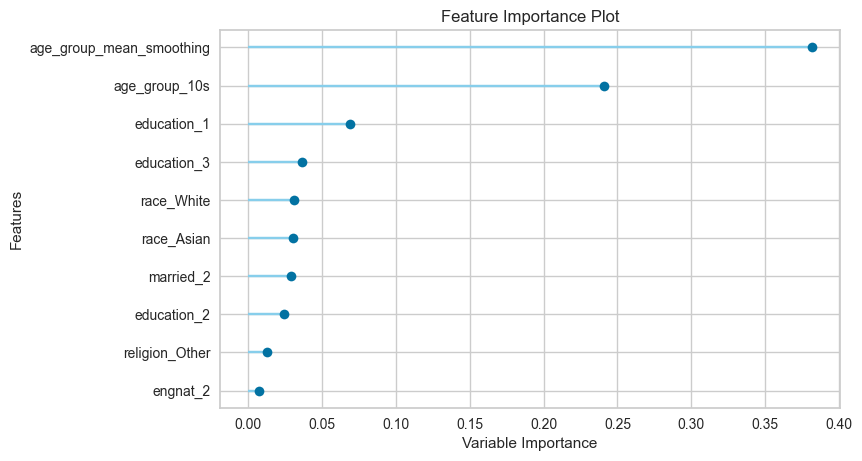

In [74]:
plot_model(estimator = gbc, plot = 'feature')

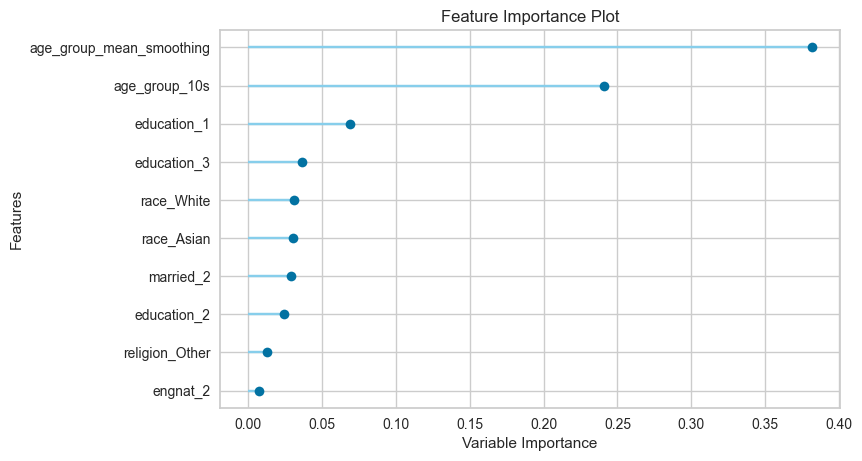

In [77]:
plot_model(estimator = gbc, plot = 'feature', system=False)

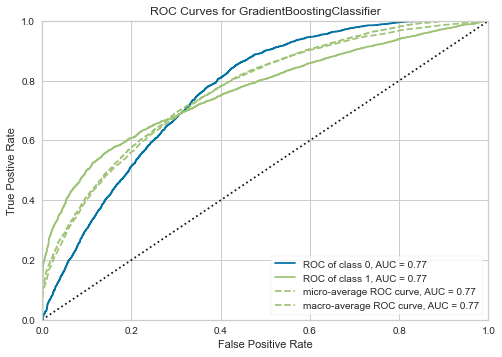

In [75]:
plot_model(estimator = gbc, plot = 'auc')

In [61]:
gbc.

<bound method BaseEstimator.get_params of GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

In [60]:
gbc.feature_importances_

array([3.63781336e-03, 2.74674881e-03, 3.18052890e-03, 1.98977300e-03,
       3.98700510e-03, 2.23822417e-03, 3.01246026e-03, 4.28409099e-03,
       3.97431103e-03, 2.73265861e-03, 8.77201486e-04, 2.71104536e-03,
       2.50220250e-03, 2.13028760e-03, 4.44809458e-03, 2.55410964e-03,
       2.93592062e-03, 2.10617220e-03, 2.64547617e-03, 2.83800798e-03,
       1.19773902e-03, 2.55596994e-03, 1.59430637e-03, 7.05155893e-04,
       3.47036789e-04, 1.59955541e-03, 3.61227146e-04, 3.81749112e-01,
       3.41277837e-04, 3.47847551e-09, 0.00000000e+00, 1.82828263e-03,
       0.00000000e+00, 3.19288647e-04, 0.00000000e+00, 0.00000000e+00,
       1.79691973e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.39062339e-04, 0.00000000e+00, 1.92697833e-03, 3.10936295e-04,
       0.00000000e+00, 0.00000000e+00, 7.43220741e-05, 0.00000000e+00,
       8.77683758e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.34638965e-09,
      

In [41]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7004,0.7679,0.6671,0.7561,0.7088,0.4028,0.4061
1,0.6863,0.7603,0.6528,0.7423,0.6947,0.3748,0.3781
2,0.6627,0.7441,0.6198,0.7236,0.6677,0.3295,0.3335
3,0.7004,0.7684,0.6628,0.7586,0.7075,0.4033,0.4071
4,0.6839,0.7566,0.6399,0.7458,0.6888,0.3715,0.3760
5,0.7075,0.7724,0.6801,0.7596,0.7176,0.4161,0.4188
6,0.6758,0.7480,0.6485,0.7290,0.6864,0.3533,0.3559
7,0.7002,0.7718,0.6671,0.7561,0.7088,0.4023,0.4056
8,0.6837,0.7516,0.6413,0.7450,0.6893,0.3708,0.3751
9,0.6499,0.7210,0.5839,0.7229,0.6460,0.3074,0.3143


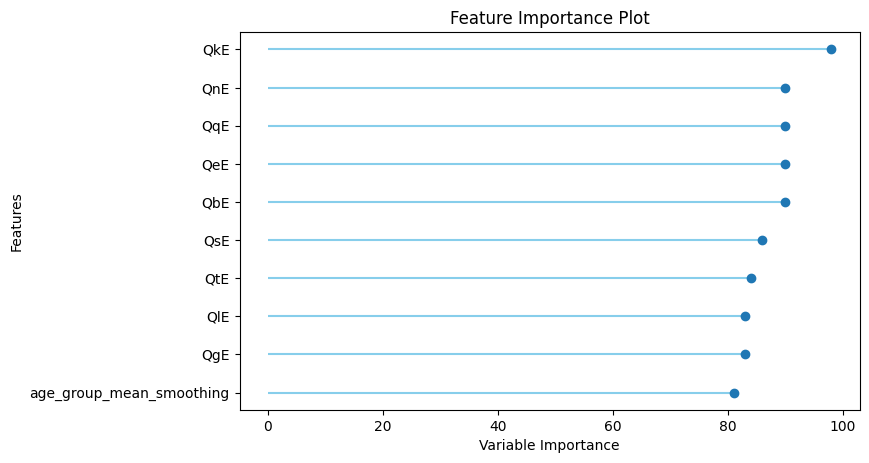

In [42]:
plot_model(estimator = lightgbm, plot = 'feature')